<a href="https://colab.research.google.com/github/Qjr2023/DP-for-Airline-Revenue-Optimization/blob/main/CS5800_9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS5800 Project - Team 9B
**Dynamic Programming for Airline Ticket Revenue Optimization**

Group Members: Fang Liu, Zihao Li, Haoyi Gao

## **Section 1: Project Overview**
This project aims to maximize airline ticket revenue by developing a dynamic programming (DP) model that optimally adjusts ticket prices based on time to departure, seat inventory, and consumer demand. The basic model incorporates price elasticity of demand to reflect the relationship between pricing and booking behavior.

## **Section 2: Data Ingestion**
In this section, we load flight data from a CSV file into a Pandas DataFrame and preprocess it to create additional features for dynamic programming analysis. The preprocessing includes calculating the number of days until the flight, constructing a unique route identifier, and engineering metrics such as price sensitivity and seats fill ratio. The processed data is then saved back to a new CSV file for further analysis. Additionally, we generate pricing scenarios and demonstrate how to prepare data for a specific route.

**Data Cleaning**

In [ ]:
from os import path
import pandas as pd
import numpy as np

def clean_flight_data(df):
    """
    Main data cleaning function to handle missing values, outliers, and data type conversions
    """
    # Handle missing values
    df['totalTravelDistance'] = df['totalTravelDistance'].fillna(df['totalTravelDistance'].median())

    # Convert date types
    df['searchDate'] = pd.to_datetime(df['searchDate'])
    df['flightDate'] = pd.to_datetime(df['flightDate'])

    # Convert boolean types
    bool_columns = ['isBasicEconomy', 'isRefundable', 'isNonStop']
    for col in bool_columns:
        df[col] = df[col].astype(bool)

    # Clean numeric columns
    numeric_columns = ['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remove extreme outliers (adjust as needed)
    df = df[df['totalFare'] > 0]
    df = df[df['seatsRemaining'] > 0]

    return df

def stratified_sample(file_path, sample_size=0.1):
    """
    Stratified sampling to ensure representativeness of key features
    """


    df = pd.read_csv(file_path)

    # Data cleaning
    df = clean_flight_data(df)

    # Create route identifier
    df['route'] = df['startingAirport'] + '_' + df['destinationAirport'] + '_' + df['legId'].astype(str)

    # Stratified sampling with include_groups=False to address deprecation warning
    sampled_df = df.groupby('route', group_keys=False).apply(
        lambda x: x.sample(frac=sample_size), include_groups=False
    )

    return sampled_df

def main():
    input_file = 'test_data.csv'
    output_file = 'test_sample_result.csv'

    sampled_df = stratified_sample(input_file)
    sampled_df.to_csv(output_file, index=False)
    print(f"Sampled data saved to {output_file}")

if __name__ == '__main__':
    main()


**Data Processing**

In [ ]:
import pandas as pd
import numpy as np

def preprocess_flight_data(df):
    """
    Prepare and transform raw flight data for dynamic programming analysis

    Args:
        df (pd.DataFrame): Raw flight data

    Returns:
        pd.DataFrame: Processed dataframe with additional features
    """
    # Convert date columns
    df['searchDate'] = pd.to_datetime(df['searchDate'])
    df['flightDate'] = pd.to_datetime(df['flightDate'])

    # Calculate days until flight
    df['days_until_flight'] = (df['flightDate'] - df['searchDate']).dt.days

    # Create unique route identifier
    df['route'] = df['startingAirport'] + '_' + df['destinationAirport'] + '_' + df['legId'].astype(str)

    # Calculate price sensitivity metric
    df['price_sensitivity'] = df['totalFare'] / df['baseFare']

    # Additional feature engineering
    df['fare_per_mile'] = df['totalFare'] / df['totalTravelDistance']
    df['seats_fill_ratio'] = df['seatsRemaining'] / df.groupby('route')['seatsRemaining'].transform('max')

    # Categorize booking periods
    df['booking_period'] = pd.cut(
        df['days_until_flight'],
        bins=[-1, 7, 30, 90, 180, np.inf],
        labels=['Last Minute', 'Short Term', 'Medium Term', 'Long Term', 'Extended']
    )

    return df

def prepare_route_data(df, route):
    """
    Prepare data for a specific route for dynamic programming analysis

    Args:
        df (pd.DataFrame): Processed flight dataframe
        route (str): Specific route to analyze

    Returns:
        pd.DataFrame: Filtered and sorted data for the route
    """
    route_data = df[df['route'] == route].copy()
    route_data.sort_values('days_until_flight', inplace=True)

    return route_data

def generate_pricing_scenarios(base_fare, num_scenarios=5):
    """
    Generate pricing scenarios for dynamic optimization

    Args:
        base_fare (float): Original base fare
        num_scenarios (int): Number of pricing scenarios

    Returns:
        list: Pricing adjustment factors
    """
    # Different pricing adjustment scenarios
    price_adjustments = [
        0.8,    # Significant discount
        0.9,    # Moderate discount
        1.0,    # Base price
        1.1,    # Slight premium
        1.2     # Higher premium
    ]

    return price_adjustments[:num_scenarios]

def main():
    # Load sampled data
    input_file = 'test_sample_result.csv'
    output_file = 'test_processed_flight_data.csv'

    # Read and process data
    df = pd.read_csv(input_file)
    processed_df = preprocess_flight_data(df)

    # Save processed data
    processed_df.to_csv(output_file, index=False)
    print(f"Processed data saved to {output_file}")

    # Example route analysis preparation
    sample_route = processed_df['route'].iloc[0]
    route_data = prepare_route_data(processed_df, sample_route)

    # Generate pricing scenarios
    pricing_scenarios = generate_pricing_scenarios(route_data['baseFare'].mean())

    print(f"Processed route: {sample_route}")
    print("Pricing scenarios:", pricing_scenarios)

if __name__ == '__main__':
    main()

Processed data saved to test_processed_flight_data.csv
Processed route: ATL_BOS
Pricing scenarios: [0.8, 0.9, 1.0, 1.1, 1.2]


## Section 3: Dynamic Programming
This script uses dynamic programming to optimize airline revenue by analyzing flight data. The `FlightRevenueAnalyzer` class evaluates pricing strategies for specific routes, simulating demand elasticity and seat availability to maximize revenue. The top routes are identified based on optimized revenue, and the results are visualized with before-and-after comparisons, highlighting revenue improvements from dynamic pricing strategies.


**Data Analyzing**

Route: IAD_SFO
Max Revenue: $6,873.50
Optimal Strategy: {'base_price': 812.4710000000001, 'seats': 8.28, 'days_until_flight': 45}
---
Route: LAX_LGA
Max Revenue: $6,830.23
Optimal Strategy: {'base_price': 807.3560000000001, 'seats': 8.28, 'days_until_flight': 45}
---
Route: OAK_PHL
Max Revenue: $6,622.43
Optimal Strategy: {'base_price': 782.793, 'seats': 8.28, 'days_until_flight': 45}
---
Route: LGA_OAK
Max Revenue: $6,372.34
Optimal Strategy: {'base_price': 1355.816, 'seats': 4.6, 'days_until_flight': 45}
---
Route: SFO_BOS
Max Revenue: $6,094.31
Optimal Strategy: {'base_price': 720.368, 'seats': 8.28, 'days_until_flight': 45}
---
Route: JFK_DEN
Max Revenue: $6,042.39
Optimal Strategy: {'base_price': 714.23, 'seats': 8.28, 'days_until_flight': 45}
---
Route: IAD_DTW
Max Revenue: $5,921.22
Optimal Strategy: {'base_price': 699.908, 'seats': 8.28, 'days_until_flight': 45}
---
Route: DFW_OAK
Max Revenue: $5,730.73
Optimal Strategy: {'base_price': 677.391, 'seats': 8.28, 'days_until_flight

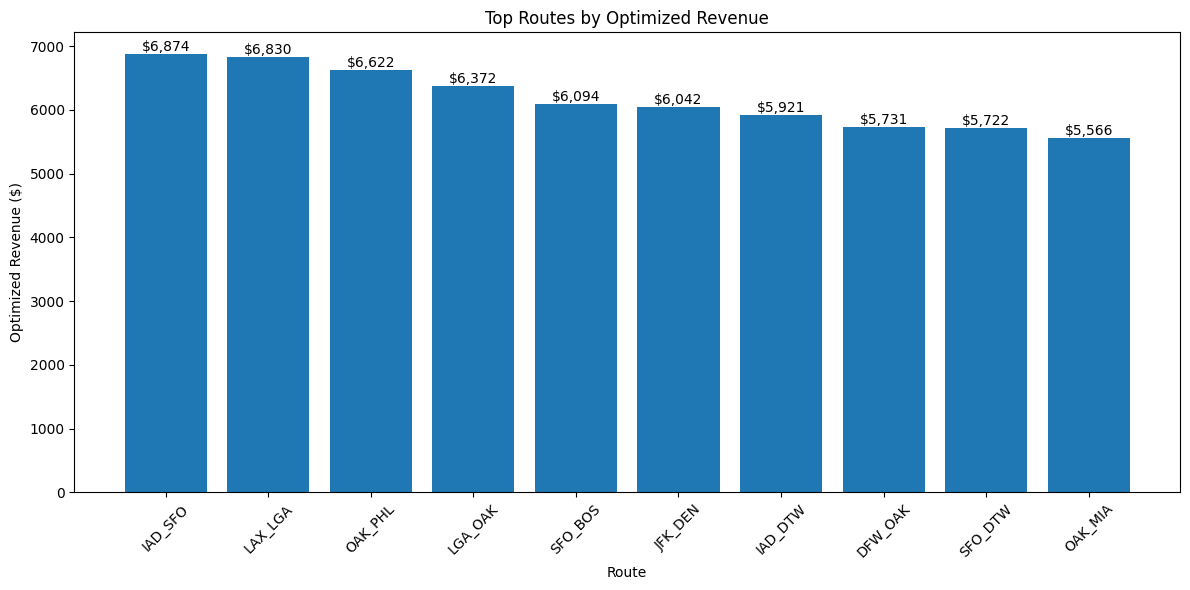

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class FlightRevenueAnalyzer:
    def __init__(self, df):
        self.df = df

    def dynamic_pricing_analysis(self, route):
        """
        Perform dynamic pricing analysis for a specific route

        Args:
            route (str): Specific route to analyze

        Returns:
            dict: Analysis results with revenue optimization details
        """
        route_data = self.df[self.df['route'] == route].sort_values('days_until_flight')

        if len(route_data) == 0:
            return None

        n = len(route_data)
        dp_revenue = np.zeros(n)
        dp_strategy = [{} for _ in range(n)]

        # Initial state
        initial_row = route_data.iloc[0]
        base_revenue = initial_row['baseFare'] * initial_row['seatsRemaining']

        dp_revenue[0] = base_revenue
        dp_strategy[0] = {
            'base_price': initial_row['baseFare'],
            'seats': initial_row['seatsRemaining'],
            'days_until_flight': initial_row['days_until_flight']
        }

        # Dynamic programming state transitions
        for i in range(1, n):
            current_row = route_data.iloc[i]

            price_adjustments = [0.8, 0.9, 1.0, 1.1, 1.2]  # Pricing factors to test
            max_revenue = float('-inf')
            best_strategy = {}

            elasticity = -0.8  # Demand elasticity assumption

            for adj in price_adjustments:
                for day_adj in range(max(0, current_row['days_until_flight'] - 15), current_row['days_until_flight'] + 15):
                    adjusted_price = current_row['baseFare'] * adj
                    base_price = current_row['baseFare']

                    # Calculate percentage price change
                    price_change = (adjusted_price - base_price) / base_price

                    # Adjusted demand using elasticity
                    adjusted_demand = current_row['seatsRemaining'] * (1 + elasticity * price_change)
                    if adjusted_demand < 0:
                        adjusted_demand = 0
                    elif adjusted_demand > 10:
                        adjusted_demand = 10

                    # Time factor: closer flights see higher demand
                    time_factor = 1 + (1 / (day_adj + 1))

                    # Calculate revenue
                    adjusted_revenue = adjusted_price * adjusted_demand * time_factor

                    # Update if better strategy found
                    if adjusted_revenue > max_revenue:
                        max_revenue = adjusted_revenue
                        best_strategy = {
                            'base_price': adjusted_price,
                            'seats': adjusted_demand,
                            'days_until_flight': day_adj
                        }

            dp_revenue[i] = max_revenue
            dp_strategy[i] = best_strategy

        return {
            'route': route,
            'max_total_revenue': dp_revenue[-1],
            'optimal_strategy': dp_strategy[-1]
        }


    def analyze_top_routes(self, top_n=10):
        """
        Analyze top routes by optimized revenue

        Args:
            top_n (int): Number of top routes to analyze

        Returns:
            list: Top routes with their revenue optimization details
        """
        routes = self.df['route'].unique()
        route_optimizations = []

        for route in routes:
            result = self.dynamic_pricing_analysis(route)
            if result:
                route_optimizations.append(result)

        route_optimizations.sort(key=lambda x: x['max_total_revenue'], reverse=True)
        return route_optimizations[:top_n]

    def visualize_route_revenues(self, route_results):
        """
        Visualize route revenues

        Args:
            route_results (list): List of route optimization results
        """
        routes = [r['route'] for r in route_results]
        revenues = [r['max_total_revenue'] for r in route_results]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(routes, revenues)
        plt.title('Top Routes by Optimized Revenue')
        plt.xlabel('Route')
        plt.ylabel('Optimized Revenue ($)')
        plt.xticks(rotation=45)

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'${height:,.0f}',
                     ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

def main():
    # Load processed data
    input_file = 'test_processed_flight_data.csv'
    df = pd.read_csv(input_file)

    # Initialize analyzer
    analyzer = FlightRevenueAnalyzer(df)

    # Analyze top routes
    top_route_results = analyzer.analyze_top_routes(top_n=10)

    # Print detailed results
    for result in top_route_results:
        print(f"Route: {result['route']}")
        print(f"Max Revenue: ${result['max_total_revenue']:,.2f}")
        print(f"Optimal Strategy: {result['optimal_strategy']}")
        print("---")

    # Visualize results
    analyzer.visualize_route_revenues(top_route_results)

if __name__ == '__main__':
    main()

**Machine Learning Model for Time Factor**

Trained Revenue Model - RMSE: 37.91

Top Routes Optimized Revenue:
     Route   Max Revenue  Optimal Price  Optimal Seats  Days Until Flight
0  LGA_OAK  1.197081e+07        554.100              7                 60
1  LAX_BOS  1.192870e+07        516.840              7                 60
2  LAX_JFK  1.187031e+07        565.956              7                 60
3  DEN_JFK  1.139550e+07        768.000              3                 60
4  OAK_LGA  1.137022e+07        634.044              7                 60
5  LAX_LGA  1.126226e+07        328.188              7                 60
6  SFO_LGA  1.125077e+07        797.016              9                 60
7  LAX_ATL  1.113130e+07        507.912              9                 60
8  JFK_LAX  1.112892e+07        511.260              7                 60
9  BOS_LAX  1.098211e+07        419.436              7                 60


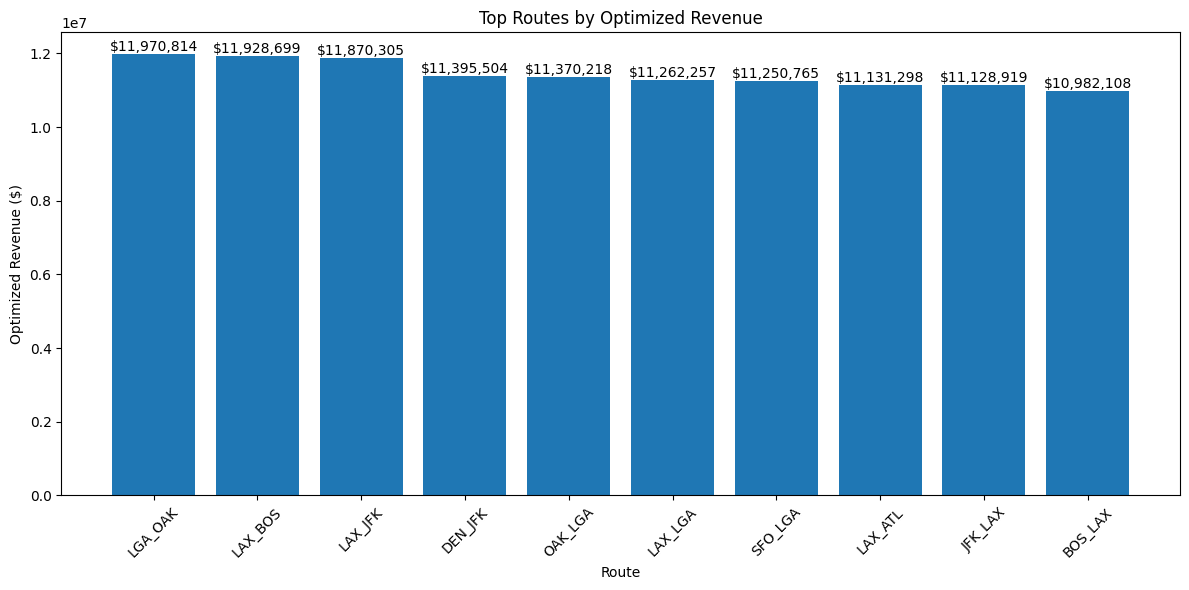

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from multiprocessing import Pool


class FlightRevenueAnalyzer:
    def __init__(self, df):
        self.df = df
        self.model = None
        self.preprocess_data()
        self.train_revenue_model()

    def preprocess_data(self):
        """
        Preprocess the DataFrame to add calculated columns and clean data.
        """
        self.df['searchDate'] = pd.to_datetime(self.df['searchDate'])
        self.df['flightDate'] = pd.to_datetime(self.df['flightDate'])
        self.df['days_until_flight'] = (self.df['flightDate'] - self.df['searchDate']).dt.days
        self.df['route'] = self.df['startingAirport'] + '_' + self.df['destinationAirport']

        # Feature engineering
        self.df['price_per_seat'] = self.df['baseFare'] / self.df['seatsRemaining']
        self.df['fare_per_distance'] = self.df['baseFare'] / self.df['totalTravelDistance']
        self.df['seats_remaining_ratio'] = self.df['seatsRemaining'] / self.df.groupby('route')['seatsRemaining'].transform('max')
        self.df['time_factor'] = 1 + 0.1 * (30 - self.df['days_until_flight'].clip(lower=0, upper=30)) / 30

        # Target variable: Revenue
        self.df['revenue'] = self.df['baseFare'] * self.df['seatsRemaining'] * self.df['time_factor']

    def train_revenue_model(self):
        """
        Train a machine learning model to predict revenue.
        """
        features = self.df[['days_until_flight', 'baseFare', 'seatsRemaining', 'price_per_seat', 'fare_per_distance', 'seats_remaining_ratio']].dropna()
        target = self.df['revenue'].dropna()
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

        self.model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
        self.model.fit(X_train, y_train)

        # Evaluate the model
        predictions = self.model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        print(f"Trained Revenue Model - RMSE: {rmse:.2f}")

    def predict_revenue_batch(self, route_data, price_adjustments):
        """
        Predict revenue for all pricing scenarios in a batch.
        """
        scenarios = []
        for _, row in route_data.iterrows():
            for adj in price_adjustments:
                adjusted_price = row['baseFare'] * adj
                price_per_seat = adjusted_price / row['seatsRemaining']
                fare_per_distance = adjusted_price / row['totalTravelDistance']
                seats_remaining_ratio = row['seatsRemaining'] / row['seatsRemaining']
                scenarios.append([row['days_until_flight'], adjusted_price, row['seatsRemaining'], price_per_seat, fare_per_distance, seats_remaining_ratio])
        scenario_df = pd.DataFrame(scenarios, columns=['days_until_flight', 'baseFare', 'seatsRemaining', 'price_per_seat', 'fare_per_distance', 'seats_remaining_ratio'])

        # Predict revenue for all scenarios
        predicted_revenues = self.model.predict(scenario_df)
        return predicted_revenues.reshape(len(route_data), -1)

    def dynamic_pricing_analysis(self, route):
        """
        Perform dynamic pricing analysis for a specific route.
        """
        route_data = self.df[self.df['route'] == route].sort_values('days_until_flight')
        if len(route_data) == 0:
            return None

        price_adjustments = [0.8, 0.9, 1.0, 1.1, 1.2]
        predicted_revenues = self.predict_revenue_batch(route_data, price_adjustments)

        # Choose the best pricing strategy for each row
        optimal_strategies = []
        for i, row in enumerate(route_data.itertuples()):
            best_idx = np.argmax(predicted_revenues[i])
            best_adjustment = price_adjustments[best_idx]
            optimal_strategies.append({
                'base_price': row.baseFare * best_adjustment,
                'seats': row.seatsRemaining,
                'days_until_flight': row.days_until_flight,
                'predicted_revenue': predicted_revenues[i, best_idx]
            })

        total_revenue = sum([strategy['predicted_revenue'] for strategy in optimal_strategies])

        return {
            'route': route,
            'max_total_revenue': total_revenue,
            'optimal_strategy': optimal_strategies[-1]
        }

    def analyze_top_routes(self, top_n=10):
        """
        Analyze top routes by optimized revenue.
        """
        routes = self.df['route'].unique()

        # Use multiprocessing to analyze routes in parallel
        with Pool(processes=4) as pool:
            route_optimizations = pool.map(self.dynamic_pricing_analysis, routes)

        # Filter out None results and sort by max_total_revenue
        route_optimizations = [r for r in route_optimizations if r]
        route_optimizations.sort(key=lambda x: x['max_total_revenue'], reverse=True)
        top_routes = route_optimizations[:top_n]

        # Create a summary DataFrame
        summary_data = {
            'Route': [r['route'] for r in top_routes],
            'Max Revenue': [r['max_total_revenue'] for r in top_routes],
            'Optimal Price': [r['optimal_strategy']['base_price'] for r in top_routes],
            'Optimal Seats': [r['optimal_strategy']['seats'] for r in top_routes],
            'Days Until Flight': [r['optimal_strategy']['days_until_flight'] for r in top_routes],
        }
        summary_df = pd.DataFrame(summary_data)

        # Print the summary table
        print("\nTop Routes Optimized Revenue:")
        print(summary_df)

        return top_routes

    def visualize_route_revenues(self, route_results):
        """
        Visualize route revenues.
        """
        routes = [r['route'] for r in route_results]
        revenues = [r['max_total_revenue'] for r in route_results]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(routes, revenues)
        plt.title('Top Routes by Optimized Revenue')
        plt.xlabel('Route')
        plt.ylabel('Optimized Revenue ($)')
        plt.xticks(rotation=45)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., height,
                     f'${height:,.0f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


def main():
    # Load processed data
    input_file = 'test_processed_flight_data.csv'
    df = pd.read_csv(input_file)

    # Initialize analyzer
    analyzer = FlightRevenueAnalyzer(df)

    # Analyze top routes
    top_routes = analyzer.analyze_top_routes(top_n=10)

    # Visualize results
    analyzer.visualize_route_revenues(top_routes)


if __name__ == '__main__':
    main()


Model with Dynamic Elasticity

In [ ]:
import pandas as pd
import numpy as np

class FlightRevenueAnalyzer:
    def __init__(self, df):
        self.df = df

    def dynamic_pricing_analysis(self, route):
        """
        Perform dynamic pricing analysis for a specific route using explicit DP states.

        Args:
            route (str): Specific route to analyze.

        Returns:
            dict: Analysis results with revenue optimization details.
        """
        route_data = self.df[self.df['route'] == route].sort_values('days_until_flight')

        if len(route_data) == 0:
            return None

        max_days = route_data['days_until_flight'].max()
        max_seats = route_data['seatsRemaining'].max()
        mean_base_fare = route_data['baseFare'].mean()

        # Initialize DP table: dp[days][seats] for revenue
        dp = np.zeros((max_days + 1, max_seats + 1))
        dp_strategy = [[{} for _ in range(max_seats + 1)] for _ in range(max_days + 1)]

        # Elasticity constant for demand adjustment
        # elasticity = -0.8  # Negative elasticity (demand decreases as price increases)
        price_adjustments = [0.8, 0.9, 1.0, 1.1, 1.2]  # Pricing factors to test

        # Iterate backward through days (since decisions depend on future states)
        for day in range(max_days, -1, -1):

            day_data = route_data[route_data['days_until_flight'] == day]
            if day_data.empty:
              continue # Use mean base fare if no data


            for seats in range(max_seats + 1):
                max_revenue = 0
                best_strategy = {}
                max_elasticity = -1.2  # Far from departure
                min_elasticity = -0.5  # Near departure
                elasticity = min_elasticity + (max_elasticity - min_elasticity) * (day / max_days)


                base_price = day_data['baseFare'].iloc[0]

                for adj in price_adjustments:
                  if not day_data.empty:
                    adjusted_price = day_data['baseFare'].iloc[0] * adj
                  else:
                    adjusted_price = base_price * adj

                    # Calculate price change percentage
                    price_change = (adjusted_price - base_price) / base_price if base_price > 0 else 0

                    # Adjust demand using elasticity
                    adjusted_demand = seats * (1 + elasticity * price_change)
                    adjusted_demand = max(0, min(round(adjusted_demand), seats))  # Keep demand within valid bounds

                    # Calculate revenue for the current step
                    revenue = adjusted_price * adjusted_demand

                    # Add future revenue if any seats remain and days remain
                    if day < max_days and seats - adjusted_demand >= 0:
                        future_revenue = dp[day + 1][int(seats - adjusted_demand)]
                        revenue += future_revenue

                    # Update the best revenue strategy
                    if revenue > max_revenue:
                        max_revenue = revenue
                        best_strategy = {
                            'base_price': adjusted_price,
                            'seats_sold': adjusted_demand,
                            'remaining_seats': seats - adjusted_demand,
                            'day': day
                        }

                dp[day][seats] = max_revenue
                dp_strategy[day][seats] = best_strategy

        # Extract optimal strategy for the entire period
        optimal_strategy = []
        day = 0
        seats = max_seats
        while day <= max_days and seats > 0:
            best_strategy = dp_strategy[day][seats]
            if not best_strategy:
                break
            optimal_strategy.append(best_strategy)
            seats -= best_strategy['seats_sold']
            day += 1
        return {
            'route': route,
            'max_total_revenue': dp[0][max_seats],
            'optimal_strategy': optimal_strategy
        }

    def analyze_top_routes(self, top_n=10):
        """
        Analyze top routes by optimized revenue.

        Args:
            top_n (int): Number of top routes to analyze.

        Returns:
            list: Top routes with their revenue optimization details.
        """
        routes = self.df['route'].unique()
        route_optimizations = []

        for route in routes:
            result = self.dynamic_pricing_analysis(route)
            if result:
                route_optimizations.append(result)

        route_optimizations.sort(key=lambda x: x['max_total_revenue'], reverse=True)
        return route_optimizations[:top_n]

    def visualize_route_revenues(self, route_results):
        """
        Visualize route revenues.

        Args:
            route_results (list): List of route optimization results.
        """
        import matplotlib.pyplot as plt

        routes = [r['route'] for r in route_results]
        revenues = [r['max_total_revenue'] for r in route_results]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(routes, revenues)
        plt.title('Top Routes by Optimized Revenue')
        plt.xlabel('Route')
        plt.ylabel('Optimized Revenue ($)')
        plt.xticks(rotation=45)

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., height,
                     f'${height:,.0f}',
                     ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


def main():
    # Load processed data
    input_file = 'test_processed_flight_data.csv'
    df = pd.read_csv(input_file)

    # Initialize analyzer
    analyzer = FlightRevenueAnalyzer(df)

    # Analyze top routes
    top_route_results = analyzer.analyze_top_routes(top_n=10)

    # Print detailed results
    for result in top_route_results:
        print(f"Route: {result['route']}")
        print(f"Max Revenue: ${result['max_total_revenue']:,.2f}")
        print(f"Optimal Strategy: {result['optimal_strategy']}")
        print("---")

    # Visualize results
    analyzer.visualize_route_revenues(top_route_results)


if __name__ == '__main__':
    main()


KeyboardInterrupt: 

Dynamic Elasticity with data from PIT Journal UNC

In [ ]:
import pandas as pd
import numpy as np

class FlightRevenueAnalyzer:
    def __init__(self, df):
        self.df = df

    def dynamic_pricing_analysis(self, route):
      """
      Perform dynamic pricing analysis for a specific route using explicit DP states.

      Args:
          route (str): Specific route to analyze.

      Returns:
          dict: Analysis results with revenue optimization details.
      """
      route_data = self.df[self.df['route'] == route].sort_values('days_until_flight')

      if len(route_data) == 0:
          return None

      max_days = route_data['days_until_flight'].max()
      max_seats = route_data['seatsRemaining'].max()

      # Initialize DP table: dp[days][seats] for revenue
      dp = np.zeros((max_days + 1, max_seats + 1))
      dp_strategy = [[{} for _ in range(max_seats + 1)] for _ in range(max_days + 1)]

      # Pricing factors to test
      price_adjustments = [0.8, 0.9, 1.0, 1.1, 1.2]

      # Function to get time-dependent elasticity
      def get_elasticity(days_until_flight):
          if 1 <= days_until_flight <= 2:
              return -0.57
          elif 3 <= days_until_flight <= 7:
              return -1.03
          elif 8 <= days_until_flight <= 14:
              return -1.36
          elif 15 <= days_until_flight <= 21:
              return -1.58
          elif 22 <= days_until_flight:
              return -1.89  # Use -1.89 for days longer than 28
          return 0  # Default (not expected to occur)

      # Iterate backward through days (since decisions depend on future states)
      for day in range(max_days, -1, -1):
          day_data = route_data[route_data['days_until_flight'] == day]

          for seats in range(max_seats + 1):
              max_revenue = 0
              best_strategy = {}

              elasticity = get_elasticity(day)  # Get elasticity based on days_until_flight

              for adj in price_adjustments:
                  adjusted_price = day_data['baseFare'].iloc[0] * adj if not day_data.empty else 0
                  base_price = day_data['baseFare'].iloc[0] if not day_data.empty else 0

                  # Calculate price change percentage
                  price_change = (adjusted_price - base_price) / base_price if base_price > 0 else 0

                  # Adjust demand using elasticity
                  adjusted_demand = seats * (1 + elasticity * price_change)
                  adjusted_demand = max(0, min(round(adjusted_demand), seats))  # Keep demand within valid bounds

                  # Calculate revenue for the current step
                  revenue = adjusted_price * adjusted_demand

                  # Add future revenue if any seats remain and days remain
                  if day < max_days and seats - adjusted_demand > 0:
                      future_revenue = dp[day + 1][int(seats - adjusted_demand)]
                      revenue += future_revenue

                  # Update the best revenue strategy
                  if revenue > max_revenue:
                      max_revenue = revenue
                      best_strategy = {
                          'base_price': adjusted_price,
                          'seats_sold': adjusted_demand,
                          'remaining_seats': seats - adjusted_demand,
                          'day': day
                      }

              dp[day][seats] = max_revenue
              dp_strategy[day][seats] = best_strategy

      # Extract optimal strategy for the entire period
      return {
          'route': route,
          'max_total_revenue': dp[-1][max_seats],
          'optimal_strategy': dp_strategy[-1][max_seats]
      }


    def analyze_top_routes(self, top_n=10):
        """
        Analyze top routes by optimized revenue.

        Args:
            top_n (int): Number of top routes to analyze.

        Returns:
            list: Top routes with their revenue optimization details.
        """
        routes = self.df['route'].unique()
        route_optimizations = []

        for route in routes:
            result = self.dynamic_pricing_analysis(route)
            if result:
                route_optimizations.append(result)

        route_optimizations.sort(key=lambda x: x['max_total_revenue'], reverse=True)
        return route_optimizations[:top_n]

    def visualize_route_revenues(self, route_results):
        """
        Visualize route revenues.

        Args:
            route_results (list): List of route optimization results.
        """
        import matplotlib.pyplot as plt

        routes = [r['route'] for r in route_results]
        revenues = [r['max_total_revenue'] for r in route_results]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(routes, revenues)
        plt.title('Top Routes by Optimized Revenue')
        plt.xlabel('Route')
        plt.ylabel('Optimized Revenue ($)')
        plt.xticks(rotation=45)

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., height,
                     f'${height:,.0f}',
                     ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


def main():
    # Load processed data
    input_file = 'test_processed_flight_data.csv'
    df = pd.read_csv(input_file)

    # Initialize analyzer
    analyzer = FlightRevenueAnalyzer(df)

    # Analyze top routes
    top_route_results = analyzer.analyze_top_routes(top_n=10)

    # Print detailed results
    for result in top_route_results:
        print(f"Route: {result['route']}")
        print(f"Max Revenue: ${result['max_total_revenue']:,.2f}")
        print(f"Optimal Strategy: {result['optimal_strategy']}")
        print("---")

    # Visualize results
    analyzer.visualize_route_revenues(top_route_results)


if __name__ == '__main__':
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'test_processed_flight_data.csv'

**unoptimized revenue**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class FlightRevenueAnalyzerUnoptimized:
    def __init__(self, df):
        self.df = df

    def calculate_unoptimized_revenue(self, route):
        """
        Calculate unoptimized revenue for a specific route.

        Args:
            route (str): Specific route to analyze.

        Returns:
            dict: Unoptimized revenue details.
        """
        route_data = self.df[self.df['route'] == route].sort_values('days_until_flight')

        if len(route_data) == 0:
            return None

        total_unoptimized_revenue = 0

        # Calculate unoptimized revenue (base fare * original demand)
        for _, row in route_data.iterrows():
            base_fare = row['baseFare']
            original_demand = row['seatsRemaining']
            revenue = base_fare * original_demand
            total_unoptimized_revenue += revenue

        return {
            'route': route,
            'total_unoptimized_revenue': total_unoptimized_revenue
        }

    def analyze_top_routes_unoptimized(self, top_n=10):
        """
        Analyze top routes by unoptimized revenue.

        Args:
            top_n (int): Number of top routes to analyze.

        Returns:
            list: Top routes with their unoptimized revenue details.
        """
        routes = self.df['route'].unique()
        route_revenues = []

        for route in routes:
            result = self.calculate_unoptimized_revenue(route)
            if result:
                route_revenues.append(result)

        route_revenues.sort(key=lambda x: x['total_unoptimized_revenue'], reverse=True)
        return route_revenues[:top_n]

    def visualize_unoptimized_revenues(self, route_results):
        """
        Visualize unoptimized revenues for routes.

        Args:
            route_results (list): List of route revenue results.
        """
        routes = [r['route'] for r in route_results]
        revenues = [r['total_unoptimized_revenue'] for r in route_results]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(routes, revenues)
        plt.title('Top Routes by Unoptimized Revenue')
        plt.xlabel('Route')
        plt.ylabel('Unoptimized Revenue ($)')
        plt.xticks(rotation=45)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., height,
                     f'${height:,.0f}',
                     ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


def main():
    # Load processed data
    input_file = 'test_processed_flight_data.csv'
    df = pd.read_csv(input_file)

    # Initialize analyzer
    analyzer = FlightRevenueAnalyzerUnoptimized(df)

    # Analyze top routes
    top_route_results = analyzer.analyze_top_routes_unoptimized(top_n=10)

    # Print detailed results
    for result in top_route_results:
        print(f"Route: {result['route']}")
        print(f"Total Unoptimized Revenue: ${result['total_unoptimized_revenue']:,.2f}")
        print("---")

    # Visualize results
    analyzer.visualize_unoptimized_revenues(top_route_results)


if __name__ == '__main__':
    main()


Haoyi Cleaning

In [ ]:
import pandas as pd
import numpy as np

def clean_flight_data(df):
    """
    Main data cleaning function to handle missing values, outliers, and data type conversions
    """
    # Handle missing values
    df['totalTravelDistance'] = df['totalTravelDistance'].fillna(df['totalTravelDistance'].median())

    # Convert date types
    df['searchDate'] = pd.to_datetime(df['searchDate'])
    df['flightDate'] = pd.to_datetime(df['flightDate'])

    # Convert boolean types
    bool_columns = ['isBasicEconomy', 'isRefundable', 'isNonStop']
    for col in bool_columns:
        df[col] = df[col].astype(bool)

    # Clean numeric columns
    numeric_columns = ['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remove extreme outliers (adjust as needed)
    df = df[df['totalFare'] > 0]
    df = df[df['seatsRemaining'] > 0]

    return df

def stratified_sample(file_path, sample_size=0.1):
    """
    Stratified sampling to ensure representativeness of key features
    """
    df = pd.read_csv(file_path)

    # Data cleaning
    df = clean_flight_data(df)

    # Create route identifier
    df['route'] = df['startingAirport'] + '_' + df['destinationAirport'] + '_' + df['legId'].astype(str)

    # Stratified sampling with include_groups=False to address deprecation warning
    sampled_df = df.groupby('route', group_keys=False).apply(
        lambda x: x.sample(frac=sample_size), include_groups=False
    )

    return sampled_df

def main():
    input_file = 'test_data.csv'
    output_file = 'test_sample_result.csv'

    sampled_df = stratified_sample(input_file)
    sampled_df.to_csv(output_file, index=False)
    print(f"Sampled data saved to {output_file}")

if __name__ == '__main__':
    main()


Haoyi Processing

In [ ]:
import pandas as pd
import numpy as np

def preprocess_flight_data(df):
    """
    Prepare and transform raw flight data for dynamic programming analysis

    Args:
        df (pd.DataFrame): Raw flight data

    Returns:
        pd.DataFrame: Processed dataframe with additional features
    """
    required_columns = [
        'legId','searchDate', 'flightDate', 'startingAirport',
        'destinationAirport', 'totalFare', 'baseFare',
        'totalTravelDistance', 'seatsRemaining'
    ]

    # Filter DataFrame to retain only the required columns
    #df = df[required_columns]
    # Convert date columns
    df['searchDate'] = pd.to_datetime(df['searchDate'])
    df['flightDate'] = pd.to_datetime(df['flightDate'])

    # Calculate days until flight
    df['days_until_flight'] = (df['flightDate'] - df['searchDate']).dt.days

    # Create unique route identifier
    df['route'] = df['startingAirport'] + '_' + df['destinationAirport'] + '_' +df['legId'].astype(str)

    # Calculate price sensitivity metric
    df['price_sensitivity'] = df['totalFare'] / df['baseFare']

    # Additional feature engineering
    df['fare_per_mile'] = df['totalFare'] / df['totalTravelDistance']
    df['seats_fill_ratio'] = df['seatsRemaining'] / df.groupby('route')['seatsRemaining'].transform('max')

    # Categorize booking periods
    df['booking_period'] = pd.cut(
        df['days_until_flight'],
        bins=[-1, 7, 30, 60, 90, np.inf],
        labels=['Last Minute', 'Short Term', 'Medium Term', 'Long Term', 'Extended']
    )

    return df

def prepare_route_data(df, route):
    """
    Prepare data for a specific route for dynamic programming analysis

    Args:
        df (pd.DataFrame): Processed flight dataframe
        route (str): Specific route to analyze

    Returns:
        pd.DataFrame: Filtered and sorted data for the route
    """
    route_data = df[df['route'] == route].copy()
    route_data.sort_values('days_until_flight', inplace=True)

    return route_data

def generate_pricing_scenarios(base_fare, num_scenarios=5):
    """
    Generate pricing scenarios for dynamic optimization

    Args:
        base_fare (float): Original base fare
        num_scenarios (int): Number of pricing scenarios

    Returns:
        list: Pricing adjustment factors
    """
    # Different pricing adjustment scenarios
    price_adjustments = [
        0.8,    # Significant discount
        0.9,    # Moderate discount
        1.0,    # Base price
        1.1,    # Slight premium
        1.2     # Higher premium
    ]

    return price_adjustments[:num_scenarios]

def main():
    # Load sampled data
    input_file = 'test_sample_result.csv'
    output_file = 'test_processed_flight_data.csv'

    # Read and process data
    df = pd.read_csv(input_file)
    processed_df = preprocess_flight_data(df)

    # Save processed data
    processed_df.to_csv(output_file, index=False)
    print(f"Processed data saved to {output_file}")

    # Example route analysis preparation
    sample_route = processed_df['route'].iloc[0]
    route_data = prepare_route_data(processed_df, sample_route)

    # Generate pricing scenarios
    pricing_scenarios = generate_pricing_scenarios(route_data['baseFare'].mean())

    print(f"Processed route: {sample_route}")
    print("Pricing scenarios:", pricing_scenarios)
    print("Route data preview:", route_data)

if __name__ == '__main__':
    main()

Haoyi Testing

In [ ]:
import pandas as pd
import numpy as np

class FlightRevenueAnalyzer:
    def __init__(self, df):
        self.df = df


    def dynamic_pricing_analysis(self, route):
        """
        Perform dynamic pricing analysis for a specific route using explicit DP states.

        Args:
            route (str): Specific route to analyze.

        Returns:
            dict: Analysis results with revenue optimization details.
        """
        route_data = self.df[self.df['route'] == route].sort_values('days_until_flight')

        if len(route_data) == 0:
            return None

        max_days = route_data['days_until_flight'].max()
        min_days = route_data['days_until_flight'].min()
        max_seats = route_data['seatsRemaining'].max()



        # Initialize DP table: dp[days][seats] for revenue
        dp = np.zeros((max_days + 1, max_seats + 1))
        dp_strategy = [[{} for _ in range(max_seats + 1)] for _ in range(max_days + 1)]

        # Pricing factors to test
        price_adjustments = [0.8, 0.9, 1.0, 1.1, 1.2]

        # Function to get time-dependent elasticity
        def get_elasticity(days_until_flight):
            if 0 <= days_until_flight <= 2:
                return -0.57
            elif 3 <= days_until_flight <= 7:
                return -1.03
            elif 8 <= days_until_flight <= 14:
                return -1.36
            elif 15 <= days_until_flight <= 21:
                return -1.58
            elif 22 <= days_until_flight:
                return -1.89  # Use -1.89 for days longer than 28
            return 0  # Default (not expected to occur)

        # Iterate backward through days (since decisions depend on future states)
        for day in range(max_days, -1, -1):
            day_data = route_data[route_data['days_until_flight'] == day]
            if day_data.empty:
                continue

            for seats in range(max_seats + 1):
                max_revenue = 0
                best_strategy = None

                elasticity = get_elasticity(day)  # Get elasticity based on days_until_flight

                for adj in price_adjustments:
                    adjusted_price = day_data['baseFare'].iloc[0] * adj
                    base_price = day_data['baseFare'].iloc[0]

                    # Calculate price change percentage
                    price_change = (adjusted_price - base_price) / base_price if base_price > 0 else 0

                    # Adjust demand using elasticity
                    adjusted_demand = seats * (1 + elasticity * price_change)
                    adjusted_demand = max(0, min(round(adjusted_demand), seats))  # Keep demand within valid bounds

                    # Calculate revenue for the current step
                    revenue = adjusted_price * adjusted_demand
                    revenue_before = base_price * seats

                    immediate_revenue = revenue

                    # Add future revenue if any seats remain and days remain
                    future_revenue = 0
                    if day < max_days and seats - adjusted_demand >= 0:
                        future_revenue = dp[day + 1][int(seats - adjusted_demand)]
                    total_revenue = immediate_revenue + future_revenue

                    # Update the best revenue strategy
                    if total_revenue > max_revenue:
                        max_revenue = total_revenue
                        best_strategy = {
                            'base_price': base_price,
                            'revenue_before': revenue_before,
                            'revenue_after': total_revenue,
                            'price_adjustment': adj,
                            'adjusted_price': adjusted_price,
                            'seats_sold': adjusted_demand,
                            'remaining_seats': seats - adjusted_demand,
                            'day': day
                        }


                dp[day][seats] = max_revenue
                if best_strategy:
                    dp_strategy[day][seats] = best_strategy
                else:
                    dp_strategy[day][seats] = None
                #print("dp_strategy",day,seats,": ", dp_strategy[day][seats])
                #print(best_strategy)

        # Extract optimal strategy for the entire period
        optimal_strategy = []
        day = 0
        seats = max_seats
        while day <= max_days and seats > 0:
           #print(dp_strategy[day][seats])
            if dp_strategy[day][seats] is None:
                break
            optimal_strategy.append(dp_strategy[day][seats])
            seats -= best_strategy['remaining_seats']
            day += 1
        #print (optimal_strategy)
        return {
            'route': route,
            'max_total_revenue': dp[min_days][max_seats],
            'optimal_strategy': optimal_strategy[1::]
        }


    def analyze_top_routes(self, top_n=10):
        """
        Analyze top routes by optimized revenue.

        Args:
            top_n (int): Number of top routes to analyze.

        Returns:
            list: Top routes with their revenue optimization details.
        """
        routes = self.df['route'].unique()
        route_optimizations = []

        for route in routes:
            result = self.dynamic_pricing_analysis(route)
            if result:
                route_optimizations.append(result)

        route_optimizations.sort(key=lambda x: x['max_total_revenue'], reverse=True)
        return route_optimizations[:top_n]

    def visualize_route_revenues(self, route_results):
        """
        Visualize route revenues with before-and-after optimization comparisons.

        Args:
            route_results (list): List of route optimization results.
        """
        import matplotlib.pyplot as plt
        import numpy as np

        routes = [r['route'] for r in route_results]
        revenues_after = [sum(step['revenue_after'] for step in r['optimal_strategy']) for r in route_results]
        revenues_before = [sum(step['revenue_before'] for step in r['optimal_strategy']) for r in route_results]

        # Calculate improvement ratios
        improvement_ratios = [(after / before - 1) * 100 if before > 0 else 0
                            for before, after in zip(revenues_before, revenues_after)]

        x = np.arange(len(routes))  # Label locations
        width = 0.35  # Width of bars

        fig, ax1 = plt.subplots(figsize=(14, 7))

        # Bars for revenues
        rects1 = ax1.bar(x - width / 2, revenues_before, width, label='Before Optimization')
        rects2 = ax1.bar(x + width / 2, revenues_after, width, label='After Optimization')

        # Add labels and title
        ax1.set_xlabel('Routes')
        ax1.set_ylabel('Revenue ($)')
        ax1.set_title('Comparison of Revenue Before and After Optimization')
        ax1.set_xticks(x)
        ax1.set_xticklabels(routes, rotation=45)
        ax1.legend()

        # Add improvement ratio as text labels on top of bars
        for idx, rect in enumerate(rects2):
            height = rect.get_height()
            ax1.text(rect.get_x() + rect.get_width() / 2., height,
                    f"{improvement_ratios[idx]:.1f}%", ha='center', va='bottom', fontsize=10, color='green')

        plt.tight_layout()
        plt.show()


def main():
    # Load processed data
    input_file = 'test_processed_flight_data.csv'
    df = pd.read_csv(input_file)

    # Initialize analyzer
    analyzer = FlightRevenueAnalyzer(df)

    # Analyze top routes
    top_route_results = analyzer.analyze_top_routes(top_n=10)

    # Print detailed results
    for result in top_route_results:
        print(f"Route: {result['route']}")
        print(f"Max Revenue: ${result['max_total_revenue']:,.2f}")
        print(f"Optimal Strategy: {result['optimal_strategy']}")
        print("---")

    # Visualize results
    analyzer.visualize_route_revenues(top_route_results)

if __name__ == '__main__':
    main()